# **First** autoencoder

## Importing data

In [29]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.decomposition import PCA

from DATA_generator import *

%matplotlib inline
import matplotlib.pyplot as plt



#using lorenzos code from R
#import rpy2.robjects as robjects
#from rpy2.robjects import pandas2ri

Real DATA

In [30]:
bigData = pd.read_csv("/home/salati/CHIRAL/Pkg/CHIRAL/Example/Muscle_exon.txt", sep=" ")
#Taking only the rythmic genes
PeriodicData=bigData.loc[["ENSG00000105516", "ENSG00000049246", "ENSG00000167074", "ENSG00000174738", "ENSG00000179094", "ENSG00000132326" , "ENSG00000170485", "ENSG00000133794","ENSG00000126368","ENSG00000008405","ENSG00000121671","ENSG00000159208"]]
DATA=torch.tensor(PeriodicData.values)
DATA=DATA.float()
E=np.array(PeriodicData.values)

true_phases=pd.read_csv("/home/salati/CHIRAL/Pkg/CHIRAL/Example/true_phi.txt",sep=" ")
true_phases=np.array(true_phases.values)
true_phases=true_phases[:,0]

Simulated DATA

N_Samples=56
N_PeriodicGenes=12
N_NonPeriodicGenes=0
N_Genes=N_PeriodicGenes+N_NonPeriodicGenes
NoiseSigma=0.04

#E , true_phases, alpha=NonUniformDataGenerator(N_Samples=N_Samples, N_PeriodicGenes=N_PeriodicGenes,noise=True, N_NonPeriodicGenes=N_NonPeriodicGenes )
E , true_phases, alpha=DataGenerator(N_Samples=N_Samples, N_PeriodicGenes=N_PeriodicGenes,noise=True, N_NonPeriodicGenes=N_NonPeriodicGenes , Means=False, NoiseSigma=NoiseSigma )

DATA=torch.from_numpy(E)
DATA=DATA.float()

In [31]:
N_Genes=DATA.shape[0]
N_Samples=DATA.shape[1]
N_Samples

57

Select gene you are interested setting varaible g in order to plot data, and supposed distribution

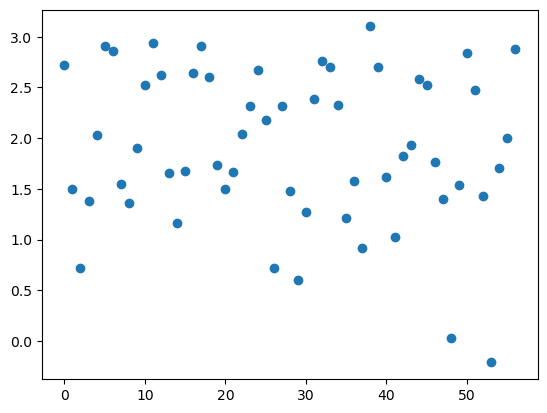

In [32]:
plt.plot(DATA[1,:], 'o')

## PCA

In [33]:
Et=np.transpose(E)
pca=PCA(n_components=2)
pca.fit(Et)

PCA(n_components=2)

In [34]:
pca.explained_variance_ratio_
PCA_base=pca.components_
PCA_base=np.array(PCA_base)
print('The two vectors are orthogonal, the scalar priduct is: ',np.matmul(PCA_base[0,:] ,PCA_base[1,:]) )


The two vectors are orthogonal, the scalar priduct is:  -2.7755575615628914e-17


In [35]:
pca_points=pca.fit_transform(Et)

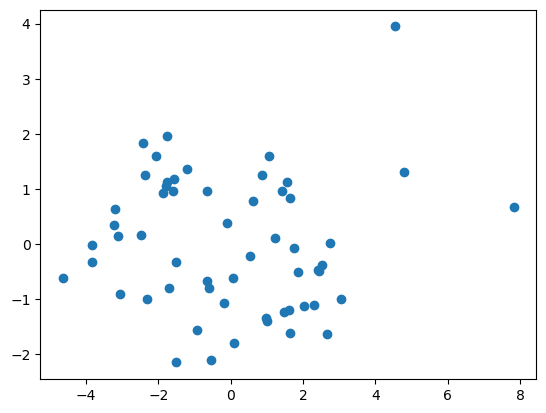

In [36]:
plt.plot(pca_points[:,0] , pca_points[:,1], 'o')

In [37]:
from DATA_generator import *
PCA_phi=np.arctan2(pca_points[:,0],pca_points[:,1])
PCAshifted_phi,madPCA=optimal_shift(PCA_phi, true_phases)
madPCA

0.33878580216854104

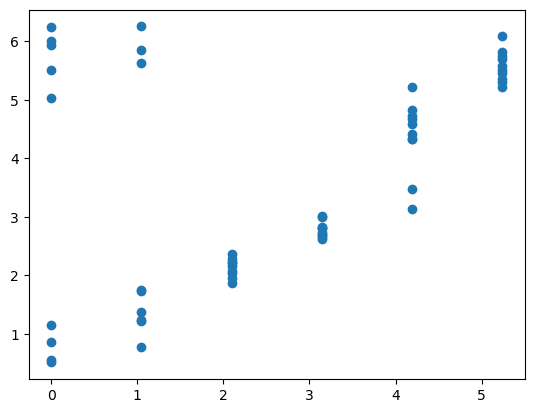

In [38]:
plt.plot(true_phases,PCAshifted_phi, 'o')

## Torch Linear

### Setting the network

In [63]:
PCA_tensor=torch.tensor(PCA_base)
PCA_tensor=PCA_tensor.float()
PCA_tensor

tensor([[-0.3415, -0.2836, -0.3255, -0.2395, -0.4008, -0.2304,  0.0701,  0.2681,
         -0.2792,  0.0499, -0.1431, -0.4982],
        [ 0.0096,  0.1267,  0.0540, -0.1128,  0.0749, -0.0783, -0.4529, -0.3995,
         -0.7616, -0.0944,  0.0129,  0.0511]])

In [64]:
class LinearEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        #self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        #self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
           
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        decoded=self.decoder(encoded)

        return decoded

Here I create an instance of the class LinearEncoder and define other important stuff like the loss function

In [65]:
model = LinearEncoder()
criterion= nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.00001)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


Adding the GPU stuff

In [66]:
#for GPU use this block

#device = torch.device('mps')
#E_t=torch.from_numpy(E)
#E_t=E_t.float()
#DATA=torch.tensor(E_t,  device=device)
#model.to(device)


# for CPU keep this line

Training cycle

In [67]:
#recon= reconstruction of the input
num_epochs=600
outputs=[]

for epoch in range(num_epochs):
 
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=model(input)
    loss=criterion(recon,input)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #added this line to compare with the circular model, thisline block the convergence
  if loss.item() < 0.0005 :
    break
  if (epoch % 30 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 6.721635341644287
epoch  30 Loss 0.42654237151145935
epoch  60 Loss 0.416856050491333
epoch  90 Loss 0.3980562686920166
epoch  120 Loss 0.35835573077201843
epoch  150 Loss 0.2766536772251129
epoch  180 Loss 0.15857775509357452
epoch  210 Loss 0.0732753798365593
epoch  240 Loss 0.0417354442179203
epoch  270 Loss 0.03669878467917442
epoch  300 Loss 0.03987226262688637
epoch  330 Loss 0.043796852231025696
epoch  360 Loss 0.046529918909072876
epoch  390 Loss 0.04811300337314606
epoch  420 Loss 0.04895677790045738
epoch  450 Loss 0.049391742795705795
epoch  480 Loss 0.04961603879928589
epoch  510 Loss 0.0497373603284359
epoch  540 Loss 0.049809109419584274
epoch  570 Loss 0.04985800385475159


Grabbing the weights of the first layer which are the analogous of the eigenvectors in PCA

In [68]:
encoder_base=model.encoder.weight
#print(encoder_base)
decoder_base=model.decoder.weight
#print(decoder_base)

Checking how the scalar product of the two vectors of the "basis" is

In [69]:
torch.dot(encoder_base[0,:],encoder_base[1,:] )

tensor(0.0592, grad_fn=<DotBackward0>)

In [70]:
NNphases=np.zeros((N_Samples,2))
for sample in range(N_Samples):
  temp=torch.matmul(encoder_base, DATA[:,sample]).detach().numpy()
  NNphases[sample,:]=temp

### Plots

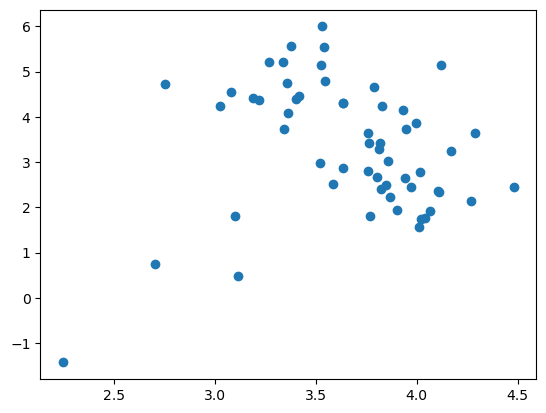

In [71]:
plt.plot(NNphases[:,0], NNphases[:,1],'o')

In [72]:
inf_phases=np.arctan2( NNphases[:,0],NNphases[:,1] )
NNshifted_phi,madNN=optimal_shift(inf_phases, true_phases)
madNN

0.8884680499759852

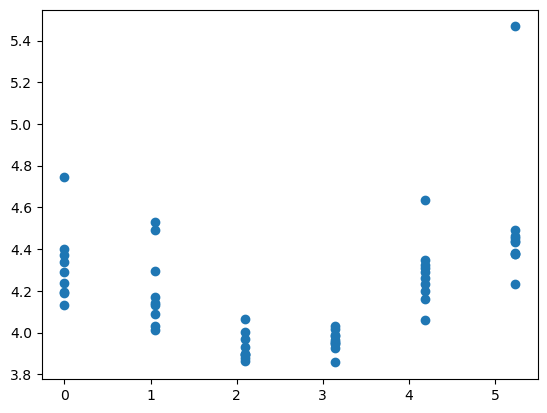

In [73]:
plt.plot(true_phases,NNshifted_phi,'o')

## Adding the "circular" activation function

### Setting the network

In [51]:
#SAME THING BUT USING SEQUENTIAL
'''
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(N_Genes, 2,bias=False)
           )
        self.decoder = nn.Sequential(
            nn.Linear(2, N_Genes,bias=False)
           )
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)
        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 
        '''

'\nclass CircularEncoder(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.encoder = nn.Sequential(\n            nn.Linear(N_Genes, 2,bias=False)\n           )\n        self.decoder = nn.Sequential(\n            nn.Linear(2, N_Genes,bias=False)\n           )\n    #fucntion that makes the input flow in the network\n    def forward(self, x):\n        encoded=self.encoder(x) #compress the input\n        encoded_circ=encoded/torch.linalg.norm(encoded)\n        decoded=self.decoder(encoded_circ)\n\n        return decoded #encoded,encoded_circ \n        '

In [52]:
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        #self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        #self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
    
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)

        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 

In [53]:
circ_model=CircularEncoder()
criterion2= nn.MSELoss()
optimizer2 = torch.optim.Adam(circ_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer2 = torch.optim.SGD(circ_model.parameters(),lr=0.001)


In [54]:
#recon= reconstruction of the input
num_epochs=300
outputs=[]

for epoch in range(num_epochs):
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=circ_model(input)
    loss=criterion2(recon,input)

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
  if (epoch % 10 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 6.985509872436523
epoch  10 Loss 4.246217250823975
epoch  20 Loss 2.776698112487793
epoch  30 Loss 1.8957518339157104
epoch  40 Loss 1.3722842931747437
epoch  50 Loss 1.0828527212142944
epoch  60 Loss 0.9098592400550842
epoch  70 Loss 0.7659251689910889
epoch  80 Loss 0.6216430068016052
epoch  90 Loss 0.49772003293037415
epoch  100 Loss 0.40010884404182434
epoch  110 Loss 0.3253546953201294
epoch  120 Loss 0.2690288722515106
epoch  130 Loss 0.2270898073911667
epoch  140 Loss 0.19606421887874603
epoch  150 Loss 0.17313562333583832
epoch  160 Loss 0.156127467751503
epoch  170 Loss 0.14341525733470917
epoch  180 Loss 0.13381381332874298
epoch  190 Loss 0.12647093832492828
epoch  200 Loss 0.12077897042036057
epoch  210 Loss 0.1163034737110138
epoch  220 Loss 0.11273517459630966
epoch  230 Loss 0.10985086113214493
epoch  240 Loss 0.1074897050857544
epoch  250 Loss 0.10553302615880966
epoch  260 Loss 0.1038946881890297
epoch  270 Loss 0.10250767320394516
epoch  280 Loss 0.10132

In [55]:
circ_encoder_base=circ_model.encoder.weight
print(encoder_base)
circ_decoder_baseC=circ_model.decoder.weight
#print(decoder_base)


Parameter containing:
tensor([[-0.2105, -0.0208,  0.0615,  0.4118, -0.0460, -0.1267, -0.0522,  0.5092,
          0.2026,  0.2068,  0.4329, -0.4809],
        [-0.2171, -0.3200, -0.3621, -0.3809, -0.3936, -0.2623,  0.1744,  0.1988,
         -0.2436,  0.0047, -0.3160, -0.3487]], requires_grad=True)


After having the values of the weight, in order to find the values of the neurons, i just reconstruct waht happens to the input until the the bottle neck (encoder linear layer + unit circle projection)

In [56]:
NNphasesC=np.zeros((2,N_Samples))
for sample in range(N_Samples):
  temp=torch.matmul(circ_encoder_base, DATA[:,sample]).detach().numpy()
  NNphasesC[:,sample]=temp
  NNphasesC[:,sample] /= np.linalg.norm(NNphasesC[:,sample])


### Plots

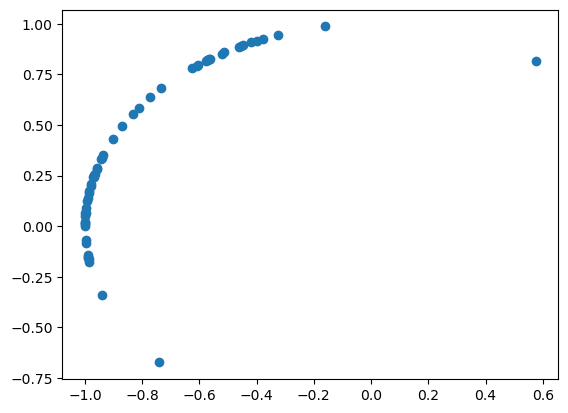

In [57]:
plt.plot(NNphasesC[0,:], NNphasesC[1,:],'o')

In [58]:
inf_phasesC=np.arctan2( NNphasesC[0,:],NNphasesC[1,:] )

NNshifted_phiC,madNNC=optimal_shift(inf_phasesC, true_phases)

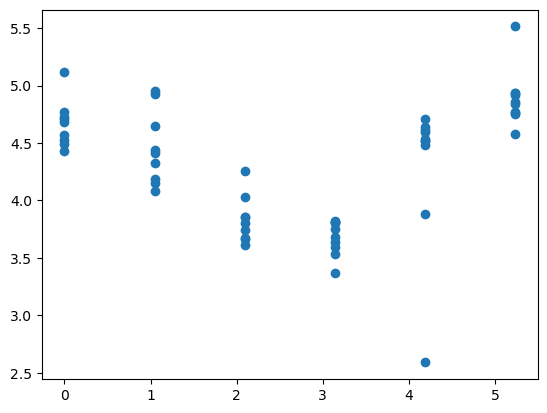

In [59]:
plt.plot(true_phases,NNshifted_phiC,'o')

In [60]:
sum((true_phases-NNshifted_phiC)**2)

338.47570349182007

Outliers really impacat this way of mesuring the goodness of the fit

In [61]:
print('PCA ', sum((true_phases-PCAshifted_phi)**2) )
print('Linear NN ', sum((true_phases-NNshifted_phi)**2) )
print('Circular NN ', sum((true_phases-NNshifted_phiC)**2) )

PCA  248.51430633716265
Linear NN  300.0886924734903
Circular NN  338.47570349182007


MAD seems more appropriate


In [62]:
print('PCA ', madPCA )
print('Linear NN ', madNN )
print('Linear NN ', madNNC )

PCA  0.33878580216854104
Linear NN  0.844995074273176
Linear NN  0.6783757097013945
